In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Завантажуємо дані CIFAR-10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Нормалізуємо зображення до діапазону [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

print("Розмір x_train:", x_train.shape)
print("Розмір x_test:", x_test.shape)

Розмір x_train: (50000, 32, 32, 3)
Розмір x_test: (10000, 32, 32, 3)


In [6]:
latent_dim = 64  # Розмір латентного простору

In [7]:
# Вхід: 32x32x3
encoder_inputs = keras.Input(shape=(32, 32, 3))

x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same", activation="relu")(
    encoder_inputs
)
x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)

# Два окремі вихідні шари для mean і logvar
mu = layers.Dense(latent_dim, name="mu")(x)
logvar = layers.Dense(latent_dim, name="logvar")(x)


# Сарmplіng (репараметризаційний трюк):
# z = mu + σ * epsilon, де sigma = exp(0.5 * logvar)
def sampling(args):
    mu, logvar = args
    epsilon = tf.random.normal(shape=tf.shape(mu))
    return mu + tf.exp(0.5 * logvar) * epsilon


z = layers.Lambda(sampling, name="z")([mu, logvar])

encoder = keras.Model(encoder_inputs, [mu, logvar, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 4096)      │          0 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │    524,416 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mu (Dense)          │ (None, 64)        │      8,256 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logvar (Dense)      │ (None, 64)        │      8,256 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 64)        │          0 │ mu[0][0],         │
│                     │                   │            │ logvar[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 560,320 (2.14 MB)

 Trainable params: 560,320 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(
    64, kernel_size=3, strides=2, padding="same", activation="relu"
)(x)
x = layers.Conv2DTranspose(
    32, kernel_size=3, strides=2, padding="same", activation="relu"
)(x)
# Останній шар з 3 каналами та sigmoid, щоб мати вихід у діапазоні [0,1]
decoder_outputs = layers.Conv2DTranspose(
    3, kernel_size=3, padding="same", activation="sigmoid"
)(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4096)           │       266,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 32, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,499 (1.23 MB)

 Trainable params: 322,499 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
vae_outputs = decoder(z)
vae = keras.Model(encoder_inputs, vae_outputs, name="vae")
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 4096)      │          0 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │    524,416 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mu (Dense)          │ (None, 64)        │      8,256 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logvar (Dense)      │ (None, 64)        │      8,256 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 64)        │          0 │ mu[0][0],         │
│                     │                   │            │ logvar[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 32, 32, 3) │    322,499 │ z[0][0]           │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 882,819 (3.37 MB)

 Trainable params: 882,819 (3.37 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs, training=None, mask=None):
        mu, logvar, z = self.encoder(inputs)
        return self.decoder(z)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            mu, logvar, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Реконструктивна втрата (binary crossentropy)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            # KL-втрата
            kl_loss = 1 + logvar - tf.square(mu) - tf.exp(logvar)
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [16]:
def dummy_loss(y_true, y_pred):
    # Повертаємо 0, бо вся логіка вже у train_step
    return 0.0


vae_model = VAE(encoder, decoder)
vae_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=dummy_loss,  # "порожня" втрата
)

In [18]:
# Для швидшого тренування можна збільшити batch_size (залежить від пам'яті GPU/CPU)
batch_size = 128
epochs = 30

history = vae_model.fit(
    x_train,
    x_train,  # y_train = x_train
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, x_test),  # y_test = x_test
)

Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - kl_loss: 12.7522 - loss: 637.7781 - reconstruction_loss: 625.0259 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - kl_loss: 12.3334 - loss: 635.4142 - reconstruction_loss: 623.0808 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - kl_loss: 12.0498 - loss: 634.0302 - reconstruction_loss: 621.9803 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - kl_loss: 11.8933 - loss: 633.5377 - reconstruction_loss: 621.6445 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - kl_loss: 12.0069 - loss: 633.0781 - reconstruction_loss: 621.0712 - val_kl_loss: 0.0

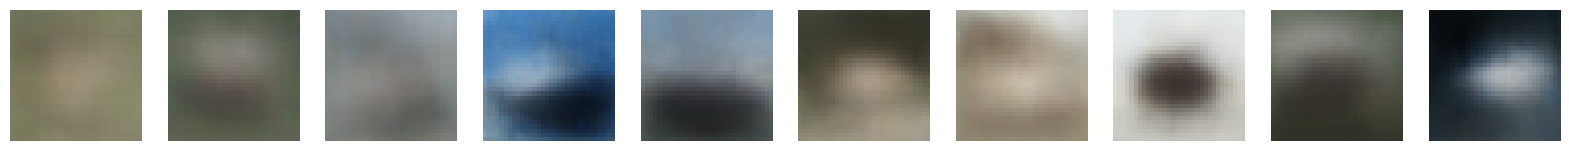

In [19]:
# Кількість зображень для генерації
n_to_generate = 10

# Генеруємо випадкові точки з Normal(0, 1)
z_sample = tf.random.normal(shape=(n_to_generate, latent_dim))

# Пропускаємо через декодер
generated_images = vae_model.decoder(z_sample)


# Функція для візуалізації
def plot_images(images, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()


# Виведемо результат
plot_images(generated_images.numpy(), n=n_to_generate)

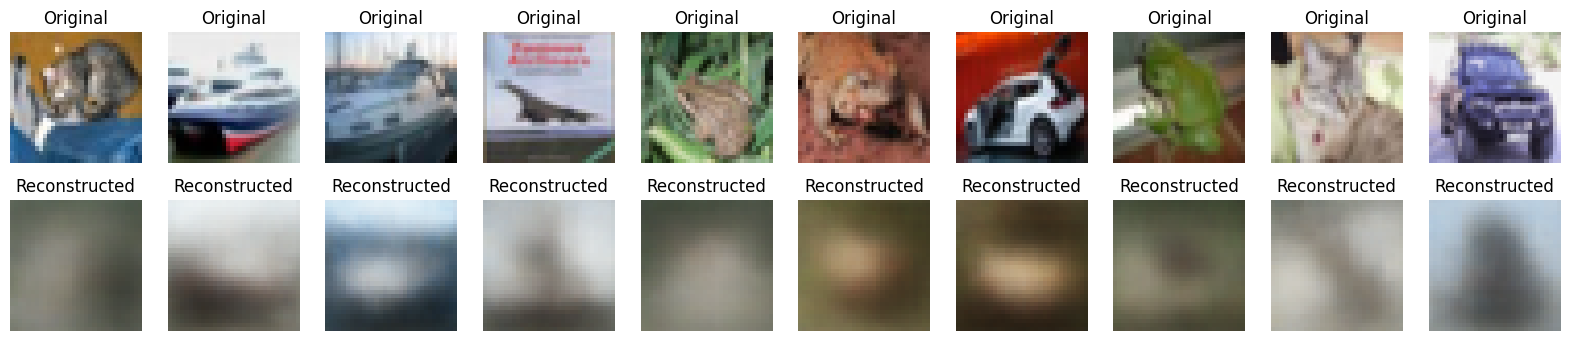

In [20]:
# Беремо перші 10 зображень з тесту
x_test_subset = x_test[:10]
mu, logvar, z = encoder(x_test_subset)
x_test_reconstructed = decoder(z)


# Відображаємо оригінали та реконструкції поруч
def plot_original_vs_recon(original, reconstructed):
    n = len(original)
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Оригінали
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        plt.title("Original")
        plt.axis("off")

        # Реконструкція
        ax = plt.subplot(2, n, n + i + 1)
        plt.imshow(reconstructed[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()


plot_original_vs_recon(x_test_subset, x_test_reconstructed.numpy())